In [ ]:
#!pip install torch
#!pip install torchvision
#!pip install tqdm

Import necessary packages and libraries

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.autograd as autograd
from torch.autograd import Variable
from myWGAN import WGANGenerator, WGANDiscriminator, WGAN
from augmentation import jitter, time_warp, permutation
from sklearn.model_selection import train_test_split
import torch.nn.init as init
import random
import pandas as pd
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import TensorDataset, DataLoader

Importing datasets

In [ ]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"


df_cpc_exchange2_url_suffix = "realAdExchange/exchange-2_cpc_results.csv"
df_cpc_exchange2_url = master_url_root + df_cpc_exchange2_url_suffix
df_cpc_normal = pd.read_csv(df_cpc_exchange2_url)

df_cpc_exchange3_url_suffix = "realAdExchange/exchange-3_cpc_results.csv"
df_cpc_exchange3_url = master_url_root + df_cpc_exchange3_url_suffix
df_cpc_with_anomaly = pd.read_csv(df_cpc_exchange3_url)

In [ ]:
# Displaying dataframe of normal values
df_cpc_normal.head()

,timestamp,value
0,2011-07-01 00:00:01,0.081965
1,2011-07-01 01:00:01,0.098972
2,2011-07-01 02:00:01,0.065314
3,2011-07-01 03:00:01,0.070663
4,2011-07-01 04:00:01,0.102490


In [ ]:
# Displaying dataframe of normal values with anomalies
df_cpc_with_anomaly.head()

,timestamp,value
0,2011-07-01 00:15:01,0.102709
1,2011-07-01 01:15:01,0.068039
2,2011-07-01 02:15:01,0.077994
3,2011-07-01 03:15:01,0.077682
4,2011-07-01 04:15:01,0.077966


In [ ]:
def plot_dates_values(data, adjust = False, show_dates = False):
    dates = data["timestamp"].to_list()
    values = data["value"].to_list()
    dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
    plt.subplots_adjust(bottom=0.2)
    plt.xticks(rotation=25)
    ax = plt.gca()
    xfmt = md.DateFormatter("%Y-%m-%d %H:%M:%S")
    ax.xaxis.set_major_formatter(xfmt)
    if adjust is True:
      ax.set_ylim([0,1])
    plt.plot(dates, values)
    plt.show()
    if show_dates is True:
      d = []
      for i in dates:
        d.append(str(i.month) + str(i.day))
      print("Number of time points in the data: ",len(d))
      print("Number of days in the data",len(set(d)))
      print("We can see below that there are only 15 records instead of 24 on the last day")
      print(data.timestamp[-18:])

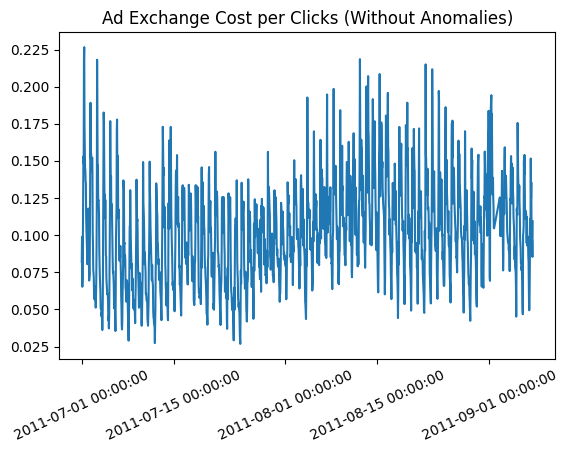

In [ ]:
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib import dates as md
plt.title('Ad Exchange Cost per Clicks (Without Anomalies)')
plot_dates_values(df_cpc_normal)

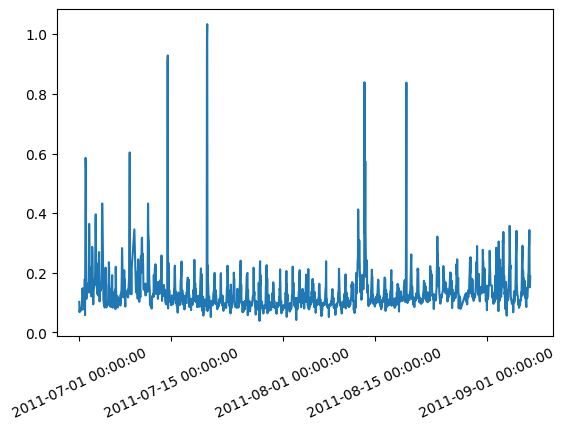

In [ ]:
plot_dates_values(df_cpc_with_anomaly)

In [ ]:
def get_value_from_df(df):
    return df.value.to_list()


# Function for Normalizing values
def normalize(values):
    mean = np.mean(values)
    values -= mean
    std = np.std(values)
    values /= std
    return values, mean, std

"""
# Get the `value` column from the training dataframe.
training_value = get_value_from_df(df_cpc_normal)
test_value = get_value_from_df(df_cpc_with_anamoly)

# Normalize `value` and save the mean and std we get,
# for normalizing test data.
training_value, training_mean, training_std = normalize(training_value)
test_value, test_mean, test_std = normalize(test_value)
print(len(training_value))
print(len(test_value))
"""

'\n# Get the `value` column from the training dataframe.\ntraining_value = get_value_from_df(df_cpc_normal)\ntest_value = get_value_from_df(df_cpc_with_anamoly)\n\n# Normalize `value` and save the mean and std we get,\n# for normalizing test data.\ntraining_value, training_mean, training_std = normalize(training_value)\ntest_value, test_mean, test_std = normalize(test_value)\nprint(len(training_value))\nprint(len(test_value))\n'

In [ ]:
import numpy as np
# Normalizing all values
values = get_value_from_df(df_cpc_normal)
normalized_values, normalized_mean, normalized_std = normalize(values)

test_values = get_value_from_df(df_cpc_with_anomaly)
test_normalized_values, normalized_mean, normalized_std = normalize(test_values)

# Split the data into training and test sets (80% of data used for training)
x_train, x_test = train_test_split(normalized_values, test_size=0.2, shuffle=False)

print("Training dataset shape: ", x_train.shape)
print("Testing dataset shape: ", x_test.shape)

Training dataset shape:  (1299,)
Testing dataset shape:  (325,)


Data augmentation with jittering

In [ ]:
num_augmentations = 5  # number of jittered versions to create
x_train_jittered = np.concatenate([jitter(x_train, sigma=0.03) for _ in range(num_augmentations)])
print("Augmented Training dataset shape: ", x_train_jittered.shape)

Augmented Training dataset shape:  (6495,)


In [ ]:
print(x_train_jittered)

[-0.60448113 -0.07039224 -1.02945414 ... -0.2915028   0.18929792
  1.14710674]


In [ ]:
TIME_STEPS = 24
np.random.seed(42)
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    return np.asarray(output)

x_train = create_sequences(x_train)

x_rough = create_sequences(test_normalized_values)

# Custom x_train for WGAN-GP model
x_train_gan = create_sequences(x_train_jittered)

In [ ]:
# Reshape the data to 3D if it is 2D
if len(x_train.shape) == 2:
    x_train_reshaped = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
else:
    x_train_reshaped = x_train

Data augmentation with permutation

In [ ]:
x_train_permuted = permutation(x_train_reshaped, max_segments=5, seg_mode="equal")
print("Permuted Training dataset shape: ", x_train_permuted.shape)

Permuted Training dataset shape:  (1275, 24, 1)


Data augmentation with time warping

In [ ]:
x_train_time_warped = time_warp(x_train_reshaped, sigma=0.2, knot=4)
print("Time Warped Training dataset shape: ", x_train_time_warped.shape)


Time Warped Training dataset shape:  (1275, 24, 1)


In [ ]:
"""
x_train = create_sequences(training_value)
x_test = create_sequences(test_value)
print("Training input shape: ", x_train.shape)
print("Training input shape for dense autoencoder: ", x_test.shape)
"""

'\nx_train = create_sequences(training_value)\nx_test = create_sequences(test_value)\nprint("Training input shape: ", x_train.shape)\nprint("Training input shape for dense autoencoder: ", x_test.shape)\n'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    alpha = torch.rand((real_samples.size(0), 1, 1)).expand_as(real_samples).to(device)
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = Variable(torch.Tensor(real_samples.shape[0], 1, 1).fill_(1.0), requires_grad=False).expand_as(real_samples).to(device)

    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(outputs=d_interpolates, inputs=interpolates,
                              grad_outputs=fake, create_graph=True, retain_graph=True,
                              only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty


In [ ]:
torch.backends.mkldnn.enabled = False

In [ ]:
TIME_STEPS = 24
latent_dim = 100  # size of the latent space
n_epochs = 45
batch_size = 32
n_critic = 5
lambda_gp = 10

# Initialize generator and discriminator
netG = WGANGenerator(latent_dim, TIME_STEPS).to(device)
netD = WGANDiscriminator(TIME_STEPS).to(device)

optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Define your schedulers, to adjust the learning rates
schedulerG = ReduceLROnPlateau(optimizerG, mode='min', factor=0.1, verbose=True)
schedulerD = ReduceLROnPlateau(optimizerD, mode='min', factor=0.1, verbose=True)

Tensor = torch.FloatTensor

# Convert the data to PyTorch tensors
x_train_tensor = torch.from_numpy(x_train_gan).float().to(device)

# Create a dataloader
dataloader = torch.utils.data.DataLoader(x_train_tensor, batch_size=batch_size, shuffle=True)

d_losses = []
g_losses = []

# Set manual seed
torch.manual_seed(42)

for epoch in range(n_epochs):
    epoch_d_loss = 0.0
    epoch_g_loss = 0.0
    for i, real_samples in enumerate(dataloader):
        real_samples = real_samples.view(real_samples.shape[0], real_samples.shape[1], 1).to(device)
        optimizerD.zero_grad()
        z = Tensor(np.random.normal(0, 1, (real_samples.shape[0], latent_dim))).to(device)

        # Temporarily disable CuDNN.
        with torch.backends.cudnn.flags(enabled=False):
            fake_samples = netG(z)
            real_validity = netD(real_samples)
            fake_validity = netD(fake_samples)
            gradient_penalty = compute_gradient_penalty(netD, real_samples.data, fake_samples.data)

        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty
        d_loss.backward()
        optimizerD.step()
        epoch_d_loss += d_loss.item()  # Add the batch's loss to our total

        # Train the generator every n_critic iterations
        if i % n_critic == 0:
            optimizerG.zero_grad()
            with torch.backends.cudnn.flags(enabled=False):
                fake_samples = netG(z)
                # We use Detach on the output of Discriminator, because we don't want to update Discriminator during the Generator's update
                fake_validity = netD(fake_samples.detach())
                g_loss = -torch.mean(fake_validity)
            g_loss.backward()
            optimizerG.step()
            epoch_g_loss += g_loss.item()  # Add the batch's loss to our total

            print(
                  "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                  % (epoch, n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
                )

    # At the end of the epoch, append average losses for the epoch to our lists
    d_losses.append(epoch_d_loss / len(dataloader))
    g_losses.append(epoch_g_loss / (len(dataloader) // n_critic))

    if epoch % 10 == 0:
        torch.save(netG.state_dict(), "generator_%d.pth" % epoch)
        torch.save(netD.state_dict(), "discriminator_%d.pth" % epoch)

[Epoch 0/45] [Batch 0/203] [D loss: 9.052398] [G loss: 0.011772]
[Epoch 0/45] [Batch 5/203] [D loss: 8.694103] [G loss: 0.012635]
[Epoch 0/45] [Batch 10/203] [D loss: 8.281441] [G loss: 0.013541]
[Epoch 0/45] [Batch 15/203] [D loss: 7.800885] [G loss: 0.014795]
[Epoch 0/45] [Batch 20/203] [D loss: 7.170752] [G loss: 0.016659]
[Epoch 0/45] [Batch 25/203] [D loss: 6.332203] [G loss: 0.019046]
[Epoch 0/45] [Batch 30/203] [D loss: 5.108377] [G loss: 0.023867]
[Epoch 0/45] [Batch 35/203] [D loss: 3.253482] [G loss: 0.034979]
[Epoch 0/45] [Batch 40/203] [D loss: 0.770267] [G loss: 0.063175]
[Epoch 0/45] [Batch 45/203] [D loss: 0.058787] [G loss: 0.080741]
[Epoch 0/45] [Batch 50/203] [D loss: 0.060007] [G loss: 0.086047]
[Epoch 0/45] [Batch 55/203] [D loss: 0.034131] [G loss: 0.089061]
[Epoch 0/45] [Batch 60/203] [D loss: 0.022132] [G loss: 0.091145]
[Epoch 0/45] [Batch 65/203] [D loss: 0.014957] [G loss: 0.091809]
[Epoch 0/45] [Batch 70/203] [D loss: 0.007684] [G loss: 0.090772]
[Epoch 0/45]

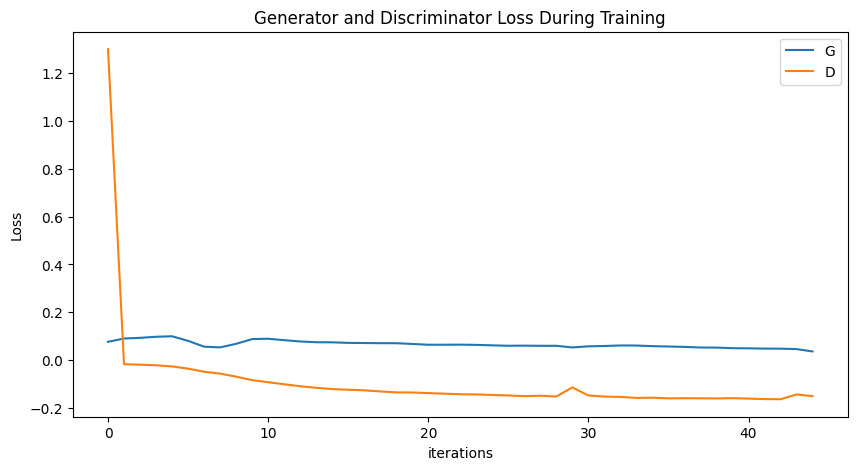

In [ ]:
# After all epochs are done, plot the losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_losses,label="G")
plt.plot(d_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

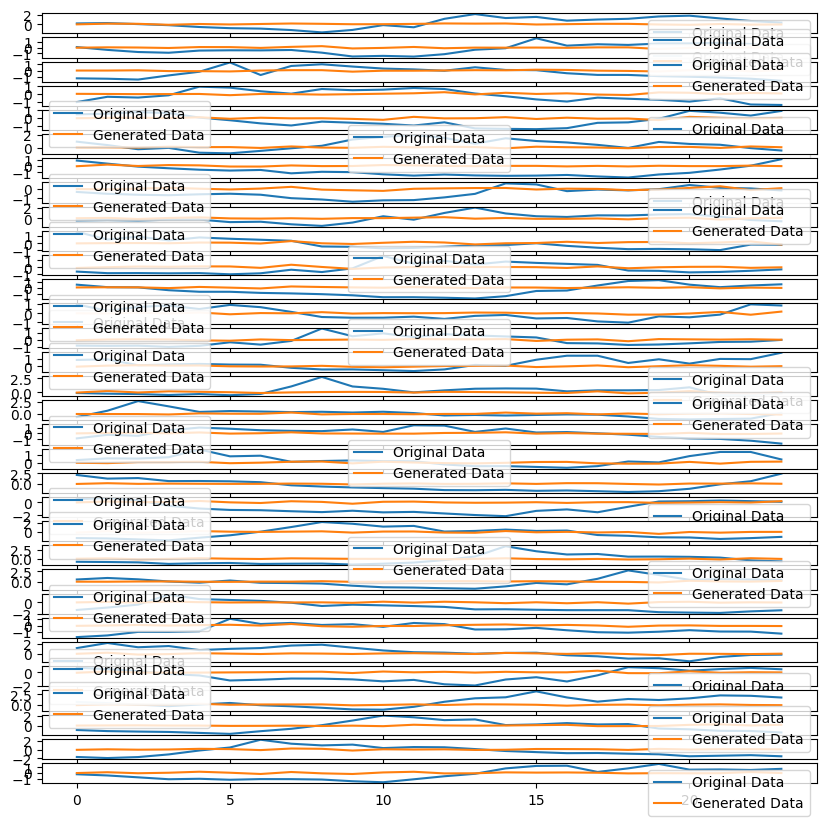

Mean Squared Error (MSE): 0.9287393676750177


In [ ]:
# Generate a batch of synthetic samples
z = Variable(torch.Tensor(np.random.normal(0, 1, (batch_size, latent_dim)))).to(device)
generated_samples = netG(z)

# Select a random subset of generated samples
num_samples_to_evaluate = generated_samples.shape[0]
selected_indices = np.random.choice(x_train.shape[0], size=num_samples_to_evaluate, replace=False)
selected_original_samples = x_train[selected_indices]

selected_original_samples = np.expand_dims(selected_original_samples, axis=-1)  # adds an extra dimension

# Convert generated samples tensor to NumPy array
generated_samples = generated_samples.cpu().detach().numpy()

# Calculate MSE between generated samples and original input data
mse = np.mean((generated_samples - selected_original_samples) ** 2)

# Visualize the selected generated samples alongside selected original data samples
fig, axes = plt.subplots(num_samples_to_evaluate, 1, figsize=(10, 10))
for i in range(num_samples_to_evaluate):
    axes[i].plot(selected_original_samples[i], label='Original Data')
    axes[i].plot(generated_samples[i], label='Generated Data')
    axes[i].legend()
plt.show()

print("Mean Squared Error (MSE):", mse)

In [ ]:
test_values = get_value_from_df(df_cpc_with_anomaly)
test_normalized_values, normalized_mean, normalized_std = normalize(test_values)
x_rough = create_sequences(test_normalized_values)

In [ ]:
Tensor = torch.FloatTensor

# Convert the data to PyTorch tensors
x_test_tensor = torch.from_numpy(x_rough).float().to(device)

# Create a dataloader
test_dataloader = torch.utils.data.DataLoader(x_test_tensor, batch_size=batch_size, shuffle=True)

In [ ]:
def compute_anomaly_score(x, G_z, netD, Lambda=0.1):
    residual_loss = torch.sum(torch.abs(x-G_z)) # Residual Loss

    # x_feature is a rich intermediate feature representation for real data x
    x_feature = netD(x)
    # G_z_feature is a rich intermediate feature representation for fake data G(z)
    G_z_feature = netD(G_z)

    discrimination_loss = torch.sum(torch.abs(x_feature-G_z_feature)) # Discrimination loss

    total_loss = (1-Lambda)*residual_loss.to(device) + Lambda*discrimination_loss
    return total_loss

loss_list = []
classifications = []
threshold = 333.27

for i, x in enumerate(test_dataloader):
    print("Batch:", i)

    x = x.view(x.shape[0], x.shape[1], 1)  # Add this line here

    z = torch.randn(x.size(0), latent_dim, device=device, requires_grad=True)

    z_optimizer = torch.optim.Adam([z],lr=1e-2)

    loss = None
    for j in range(500): # Set your iteration range
        netG.train()
        gen_fake = netG(z)
        loss = compute_anomaly_score(x.to(device), gen_fake, netD)
        loss.backward()
        z_optimizer.step()
        # Zero out the gradients before the next iteration
        z_optimizer.zero_grad()

    loss_list.append(loss.item()) # Store the loss from the final iteration
    classification = 'Anomalous' if loss.item() > threshold else 'Normal'
    classifications.append(classification)

    print('~~~~~~~~loss={} ~~~~~~~~~~'.format(loss.item()))

Batch: 0
~~~~~~~~loss=211.2753448486328 ~~~~~~~~~~
Batch: 1
~~~~~~~~loss=226.41123962402344 ~~~~~~~~~~
Batch: 2
~~~~~~~~loss=258.6531066894531 ~~~~~~~~~~
Batch: 3
~~~~~~~~loss=190.30824279785156 ~~~~~~~~~~
Batch: 4
~~~~~~~~loss=224.9641876220703 ~~~~~~~~~~
Batch: 5
~~~~~~~~loss=180.12051391601562 ~~~~~~~~~~
Batch: 6
~~~~~~~~loss=191.7817840576172 ~~~~~~~~~~
Batch: 7
~~~~~~~~loss=237.90367126464844 ~~~~~~~~~~
Batch: 8
~~~~~~~~loss=222.8130340576172 ~~~~~~~~~~
Batch: 9
~~~~~~~~loss=285.9195861816406 ~~~~~~~~~~
Batch: 10
~~~~~~~~loss=215.78135681152344 ~~~~~~~~~~
Batch: 11
~~~~~~~~loss=194.5712890625 ~~~~~~~~~~
Batch: 12
~~~~~~~~loss=212.5852508544922 ~~~~~~~~~~
Batch: 13
~~~~~~~~loss=248.17831420898438 ~~~~~~~~~~
Batch: 14
~~~~~~~~loss=239.08497619628906 ~~~~~~~~~~
Batch: 15
~~~~~~~~loss=210.72291564941406 ~~~~~~~~~~
Batch: 16
~~~~~~~~loss=248.323974609375 ~~~~~~~~~~
Batch: 17
~~~~~~~~loss=213.63821411132812 ~~~~~~~~~~
Batch: 18
~~~~~~~~loss=265.6614685058594 ~~~~~~~~~~
Batch: 19
~~~~~~~

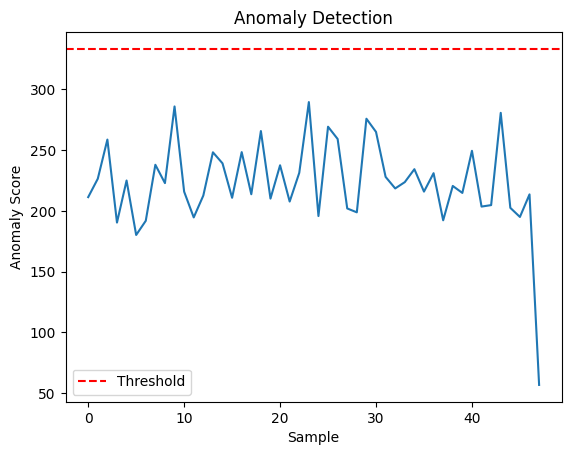

Sample 1: Normal
Sample 2: Normal
Sample 3: Normal
Sample 4: Normal
Sample 5: Normal
Sample 6: Normal
Sample 7: Normal
Sample 8: Normal
Sample 9: Normal
Sample 10: Normal
Sample 11: Normal
Sample 12: Normal
Sample 13: Normal
Sample 14: Normal
Sample 15: Normal
Sample 16: Normal
Sample 17: Normal
Sample 18: Normal
Sample 19: Normal
Sample 20: Normal
Sample 21: Normal
Sample 22: Normal
Sample 23: Normal
Sample 24: Normal
Sample 25: Normal
Sample 26: Normal
Sample 27: Normal
Sample 28: Normal
Sample 29: Normal
Sample 30: Normal
Sample 31: Normal
Sample 32: Normal
Sample 33: Normal
Sample 34: Normal
Sample 35: Normal
Sample 36: Normal
Sample 37: Normal
Sample 38: Normal
Sample 39: Normal
Sample 40: Normal
Sample 41: Normal
Sample 42: Normal
Sample 43: Normal
Sample 44: Normal
Sample 45: Normal
Sample 46: Normal
Sample 47: Normal
Sample 48: Normal


In [ ]:
# Visualize the classifications
plt.plot(loss_list)
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel('Sample')
plt.ylabel('Anomaly Score')
plt.title('Anomaly Detection')
plt.legend()
plt.show()

# Print the classifications
for i, classification in enumerate(classifications):
    print(f"Sample {i+1}: {classification}")

In [ ]:
import numpy as np

# Calculate mean and standard deviation of anomaly scores
mean_score = np.mean(loss_list)
std_score = np.std(loss_list)

# Set threshold as mean plus k times standard deviation
k = 2  # Adjust this value based on your requirements
threshold = mean_score + k * std_score

print("Mean Score:", mean_score)
print("Standard Deviation:", std_score)
print("Threshold:", threshold)


Mean Score: 223.01258254051208
Standard Deviation: 36.49468137778924
Threshold: 296.0019452960906


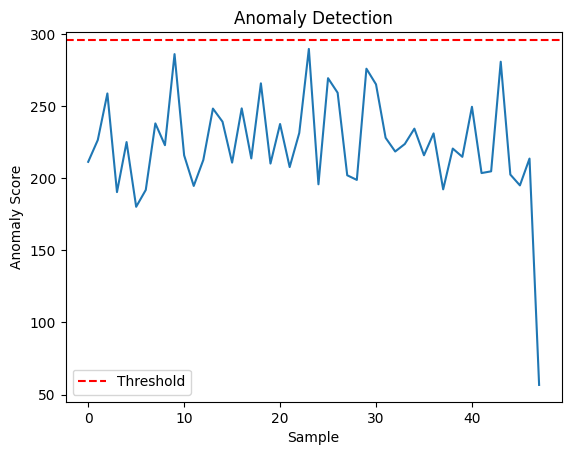

Sample 1: Normal
Sample 2: Normal
Sample 3: Normal
Sample 4: Normal
Sample 5: Normal
Sample 6: Normal
Sample 7: Normal
Sample 8: Normal
Sample 9: Normal
Sample 10: Normal
Sample 11: Normal
Sample 12: Normal
Sample 13: Normal
Sample 14: Normal
Sample 15: Normal
Sample 16: Normal
Sample 17: Normal
Sample 18: Normal
Sample 19: Normal
Sample 20: Normal
Sample 21: Normal
Sample 22: Normal
Sample 23: Normal
Sample 24: Normal
Sample 25: Normal
Sample 26: Normal
Sample 27: Normal
Sample 28: Normal
Sample 29: Normal
Sample 30: Normal
Sample 31: Normal
Sample 32: Normal
Sample 33: Normal
Sample 34: Normal
Sample 35: Normal
Sample 36: Normal
Sample 37: Normal
Sample 38: Normal
Sample 39: Normal
Sample 40: Normal
Sample 41: Normal
Sample 42: Normal
Sample 43: Normal
Sample 44: Normal
Sample 45: Normal
Sample 46: Normal
Sample 47: Normal
Sample 48: Normal


In [ ]:
# Classify each anomaly score as normal or anomalous
classifications = ['Normal' if score <= threshold else 'Anomalous' for score in loss_list]

# Visualize the classifications
plt.plot(loss_list)
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel('Sample')
plt.ylabel('Anomaly Score')
plt.title('Anomaly Detection')
plt.legend()
plt.show()

# Print the classifications
for i, classification in enumerate(classifications):
    print(f"Sample {i+1}: {classification}")

LSTM based autoencoder

In [ ]:
# Get the `value` column from the training dataframe.
training_value = get_value_from_df(df_cpc_normal)

# Normalize `value` and save the mean and std we get,
# for normalizing test data.
training_value, training_mean, training_std = normalize(training_value)
len(training_value)


x_train = create_sequences(training_value)
print("Training input shape: ", x_train.shape)

Training input shape:  (1600, 24)


In [ ]:
TIME_STEPS = 24
import torch
from torch import nn
from torch.nn import functional as F

class LSTMModel(nn.Module):
    def __init__(self, time_steps):
        super(LSTMModel, self).__init__()
        self.time_steps = time_steps
        self.lstm1 = nn.LSTM(input_size=1, hidden_size=128, num_layers=1, batch_first=True)
        self.dropout1 = nn.Dropout(0.1)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=64, num_layers=1, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.lstm3 = nn.LSTM(input_size=64, hidden_size=64, num_layers=1, batch_first=True)
        self.dropout3 = nn.Dropout(0.2)
        self.lstm4 = nn.LSTM(input_size=64, hidden_size=128, num_layers=1, batch_first=True)
        self.dropout4 = nn.Dropout(0.2)
        self.fc = nn.Linear(128, 1)

    def forward(self, x):
      x, _ = self.lstm1(x)
      x = F.relu(x)
      x = self.dropout1(x)
      x, _ = self.lstm2(x)
      x = F.relu(x)
      x = self.dropout2(x)
      x, _ = self.lstm3(x)
      x = F.relu(x)
      x = self.dropout3(x)
      x, _ = self.lstm4(x)
      x = F.relu(x)
      x = self.dropout4(x)
      # Apply linear transformation for each time step
      x = torch.stack([self.fc(x[:, i, :]) for i in range(x.shape[1])], dim=1)
      return x



input_size = 1
hidden_size = 128
batch_size = 32


model = LSTMModel(TIME_STEPS)
print(model)

LSTMModel(
  (lstm1): LSTM(1, 128, batch_first=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (lstm2): LSTM(128, 64, batch_first=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (lstm3): LSTM(64, 64, batch_first=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (lstm4): LSTM(64, 128, batch_first=True)
  (dropout4): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


In [ ]:
print(type(x_train))

<class 'numpy.ndarray'>


In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=5, min_lr=0.000001, verbose=True)

# Convert the data to PyTorch tensors and reshape
x_train_tensor = torch.from_numpy(x_train.reshape(-1, TIME_STEPS, 1)).float()

# Training loop
for epoch in range(32):
    running_loss = 0.0
    optimizer.zero_grad()

    # Forward pass
    outputs = model(x_train_tensor)

    # Compute loss
    loss = criterion(outputs, x_train_tensor)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    # Print progress
    print(f"Epoch {epoch+1}/{32}, Loss: {running_loss:.4f}")

    # Adjust learning rate
    scheduler.step(loss)

Epoch 1/32, Loss: 0.9944
Epoch 2/32, Loss: 0.9939
Epoch 3/32, Loss: 0.9941
Epoch 4/32, Loss: 0.9938
Epoch 5/32, Loss: 0.9936
Epoch 6/32, Loss: 0.9934
Epoch 7/32, Loss: 0.9932
Epoch 8/32, Loss: 0.9925
Epoch 9/32, Loss: 0.9920
Epoch 10/32, Loss: 0.9915
Epoch 11/32, Loss: 0.9905
Epoch 12/32, Loss: 0.9892
Epoch 13/32, Loss: 0.9878
Epoch 14/32, Loss: 0.9859
Epoch 15/32, Loss: 0.9833
Epoch 16/32, Loss: 0.9800
Epoch 17/32, Loss: 0.9761
Epoch 18/32, Loss: 0.9709
Epoch 19/32, Loss: 0.9639
Epoch 20/32, Loss: 0.9551
Epoch 21/32, Loss: 0.9440
Epoch 22/32, Loss: 0.9290
Epoch 23/32, Loss: 0.9117
Epoch 24/32, Loss: 0.8880
Epoch 25/32, Loss: 0.8595
Epoch 26/32, Loss: 0.8225
Epoch 27/32, Loss: 0.7767
Epoch 28/32, Loss: 0.7322
Epoch 29/32, Loss: 0.6994
Epoch 30/32, Loss: 0.6780
Epoch 31/32, Loss: 0.6484
Epoch 32/32, Loss: 0.6517


In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.legend()
plt.show()

NameError: ignored

In [ ]:
def calculate_loss(model, dataloader):
    model.eval()
    losses = []
    pred_data = []
    with torch.no_grad():
        for inputs, _ in dataloader:
            outputs = model(inputs)
            loss = torch.mean(torch.abs(inputs - outputs), dim=1)
            losses.extend(loss.tolist())
            pred_data.extend(outputs.tolist())
    return losses, pred_data

train_mae_loss, pred_data = calculate_loss(model, ae_train_loader)

In [ ]:
plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

In [ ]:
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)